<h3>Length of Stay Regression Model Building and Exploration</h3><br />
This notebook shows the process of building regression models for length of stay. It shows the data distribution, noramlization process, baseline performance of different regression models, a hypertuned version of the best performing model, and performance on a normalized dataset.

In [2]:
import sys
import platform
plat = platform.system()
if plat == 'Windows':
    sys.path.insert(0, '..\src\helpers')
    sys.path.insert(0, '..\src\models')
elif plat =='Linux' or plat=='Darwin':
    sys.path.insert(0, '../src/helpers')
    sys.path.insert(0, '../src/models')

from data_cleaners import *
from model_building_helpers import *
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
data_file_path = '../data'
all_patient_df = load_data('all', data_file_path)

all


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<ipython-input-4-2912fa75ad96>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


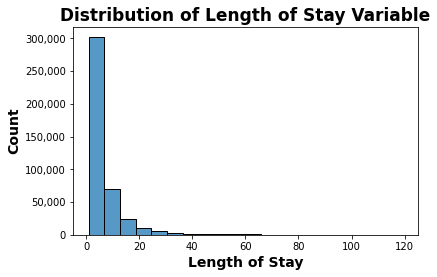

In [4]:
#Plot distibution of length of stay target variable
sns.histplot(all_patient_df['Length of Stay'], bins=20, palette='skyblue', linewidth=1)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Length of Stay', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Length of Stay Variable', fontsize=17, fontweight='bold')
plt.tight_layout(rect = [0, 0, 1, 0.988])

<ipython-input-18-51f2d0b2071b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
<ipython-input-18-51f2d0b2071b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels([x for x in current_values_x], fontsize=16)
<ipython-input-18-51f2d0b2071b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
<ipython-input-18-51f2d0b2071b>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels([x for x in current_values_x], fontsize=16)
<ipython-input-18-51f2d0b2071b>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
<ipython-input-18-51f2d0b20

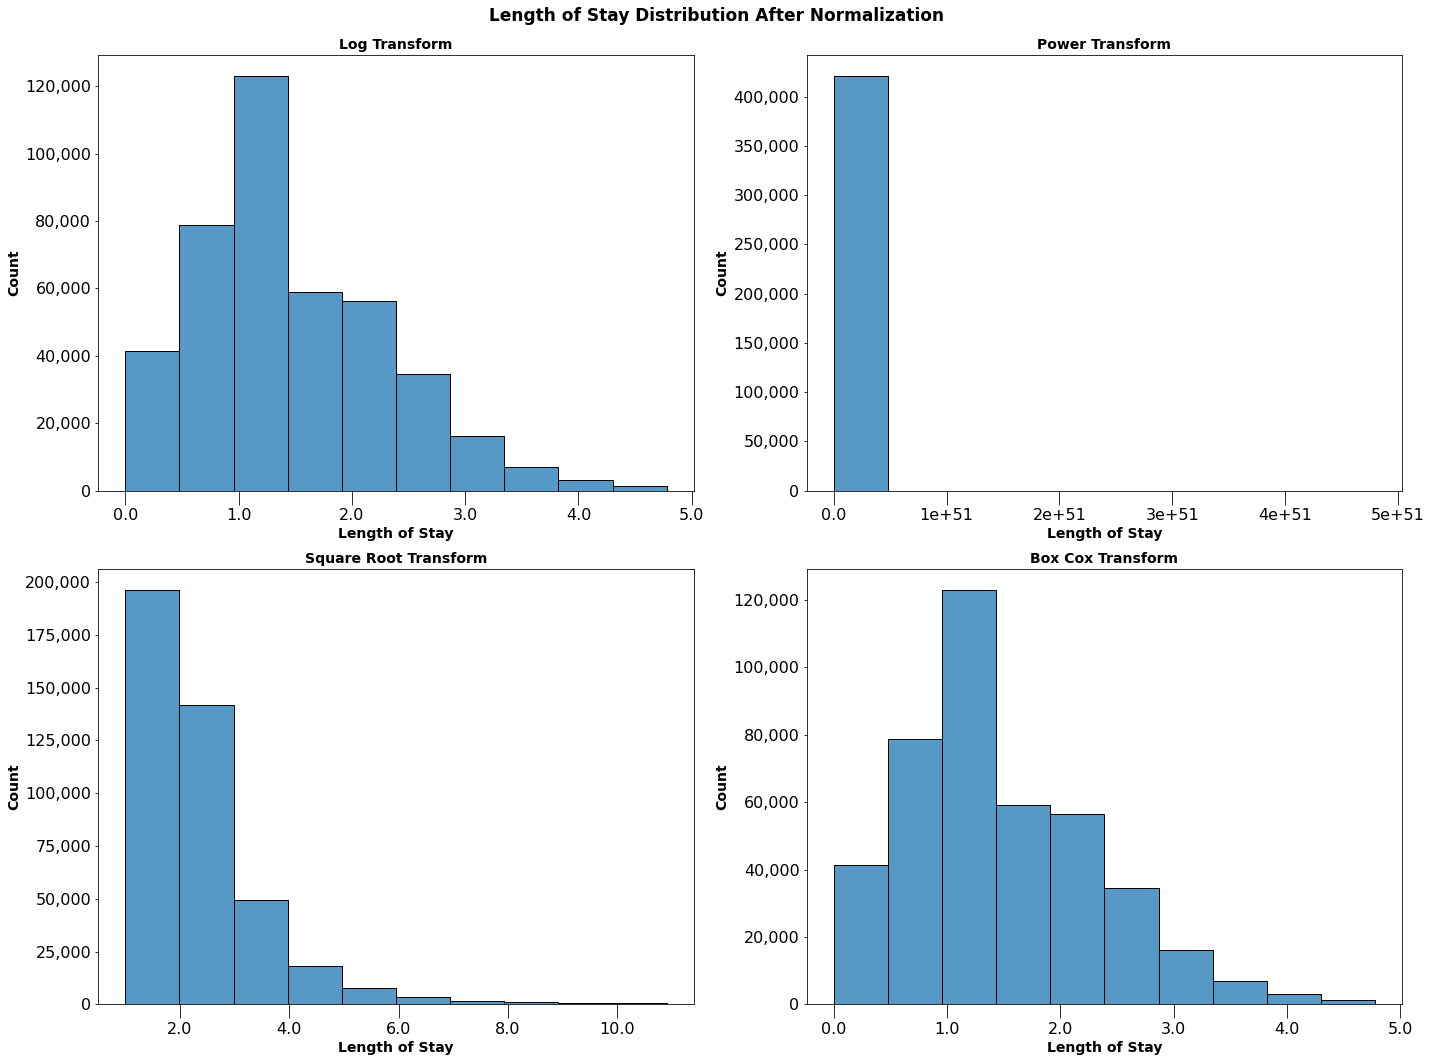

In [18]:
#Plot distibution of length of stay target variable
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=False)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Length of Stay Distribution After Normalization', fontsize=17, fontweight='bold')

sns.histplot(ax=axes[0, 0], data=np.log(all_patient_df['Length of Stay']), bins=10, palette='skyblue')
current_values_y = axes[0, 0].get_yticks()
axes[0, 0].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
current_values_x = axes[0, 0].get_xticks()
axes[0, 0].set_xticklabels([x for x in current_values_x], fontsize=16)
axes[0, 0].set_title('Log Transform', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Length of Stay', fontweight='bold', fontsize=14)
axes[0, 0].set_ylabel('Count', fontweight='bold', fontsize=14)
axes[0, 0].tick_params(axis='x', size=14)

sns.histplot(ax=axes[0, 1], data=np.exp(all_patient_df['Length of Stay']), bins=10, palette='skyblue')
current_values_y = axes[0, 1].get_yticks()
axes[0, 1].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
current_values_x = axes[0, 1].get_xticks()
axes[0, 1].set_xticklabels([x for x in current_values_x], fontsize=16)
axes[0, 1].set_title('Power Transform', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Length of Stay', fontweight='bold', fontsize=14)
axes[0, 1].set_ylabel('Count', fontweight='bold', fontsize=14)
axes[0, 1].tick_params(axis='x', size=14)

sns.histplot(ax=axes[1, 0], data=np.sqrt(all_patient_df['Length of Stay']), bins=10, palette='skyblue')
current_values_y = axes[1, 0].get_yticks()
axes[1, 0].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
current_values_x = axes[1, 0].get_xticks()
axes[1, 0].set_xticklabels([x for x in current_values_x], fontsize=16)
axes[1, 0].set_title('Square Root Transform', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Length of Stay', fontweight='bold', fontsize=14)
axes[1, 0].set_ylabel('Count', fontweight='bold', fontsize=14)
axes[1, 0].tick_params(axis='x', size=14)

sns.histplot(ax=axes[1, 1], data=stats.boxcox(all_patient_df['Length of Stay'], 0), bins=10, palette='skyblue')
current_values_y = axes[1, 1].get_yticks()
axes[1, 1].set_yticklabels(['{:,.0f}'.format(x) for x in current_values_y], fontsize=16)
current_values_x = axes[1, 1].get_xticks()
axes[1, 1].set_xticklabels([x for x in current_values_x], fontsize=16)
axes[1, 1].set_title('Box Cox Transform', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Length of Stay', fontweight='bold', fontsize=14)
axes[1, 1].set_ylabel('Count', fontweight='bold', fontsize=14)
axes[1, 1].tick_params(axis='x', size=14)

plt.tight_layout(rect = [0, 0, 1, 0.988])

In [6]:
#Since training all the data takes a long time, take a stratified sample of the data for initial baseline model performance testing
if len(all_patient_df) > 30000:
    all_patient_stratified_sample_df = all_patient_df.groupby('Length of Stay', group_keys=False).apply(lambda x: x.sample(int(np.rint(30000*len(x)/len(all_patient_df))))).sample(frac=1).reset_index(drop=True)
else:
    all_patient_stratified_sample_df = all_patient_df.copy()

X = all_patient_stratified_sample_df.loc[:, ~all_patient_stratified_sample_df.columns.isin(['Length of Stay', 'Total Costs', 'Total Charges'])]
y = all_patient_stratified_sample_df[['Length of Stay']]

categorical_columns = list(all_patient_stratified_sample_df.select_dtypes(include='object'))

X = pd.get_dummies(X)

X = X.loc[:, ~X.columns.isin(categorical_columns)]
y['Length of Stay'] = y['Length of Stay'].astype('float64')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

<ipython-input-6-430ddbde3cee>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Length of Stay'] = y['Length of Stay'].astype('float64')


In [7]:
from sklearn.model_selection import cross_validate


#Train baseline models (default parameters) on unnormalized data
models =  {
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'DecisionTreeRegression': DecisionTreeRegressor(random_state=42),
    'GradientBoostedRegressor': GradientBoostingRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42, n_estimators = 10) #Set this parameter so the model can run faster
}

model_scores = []


scoring = {'r2': 'r2',
           'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error'}

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    cv_scores = cross_validate(models[model_key], X, np.ravel(y), cv=kf, scoring=scoring)
    # Append the results
    model_scores.append({'Model' : model_key,
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


LinearRegression
RidgeRegression


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Lasso


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


DecisionTreeRegression


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


RandomForestRegressor


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


<ipython-input-8-f8856f9c97b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df['avg_r2_score'][scores_df['avg_r2_score'] < 0] = 0
<ipython-input-8-f8856f9c97b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df['avg_mae_score'][scores_df['avg_mae_score'] < -200] = 0
<ipython-input-8-f8856f9c97b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df['avg_mse_score'][scores_df['avg_mse_score'] < -200] = 0
<ipyth

[Text(0, 0.0, '0.0'),
 Text(0, 20.0, '20.0'),
 Text(0, 40.0, '40.0'),
 Text(0, 60.0, '60.0'),
 Text(0, 80.0, '80.0'),
 Text(0, 100.0, '100.0'),
 Text(0, 120.0, '120.0')]

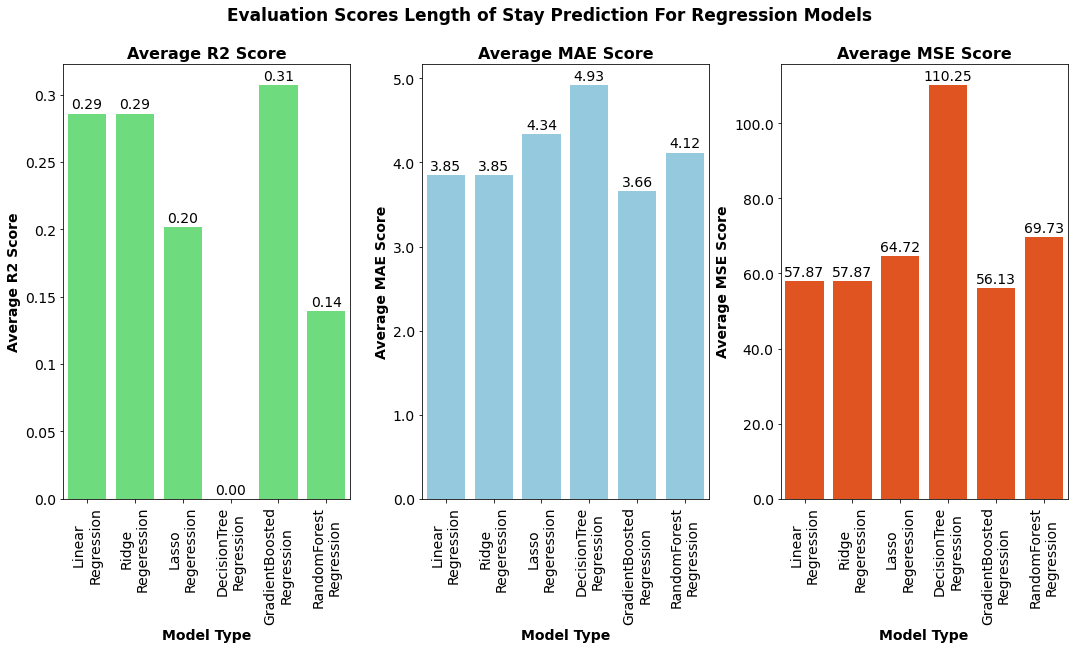

In [8]:
scores_df = pd.DataFrame(data=model_scores)

#Change any negative r2 score to 0
scores_df['avg_r2_score'][scores_df['avg_r2_score'] < 0] = 0
scores_df['avg_mae_score'][scores_df['avg_mae_score'] < -200] = 0
scores_df['avg_mse_score'][scores_df['avg_mse_score'] < -200] = 0

#Plot distibution of length of stay target variable
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=False)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Evaluation Scores Length of Stay Prediction For Regression Models', fontsize=17, fontweight='bold')

sns.barplot(ax=axes[0], x=scores_df['Model'], y=scores_df['avg_r2_score'], palette=['#5CED73'])
axes[0].set_title('Average R2 Score', fontweight='bold', fontsize=16)
axes[0].set_ylabel('Average R2 Score', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Model Type', fontweight='bold', fontsize=14)
axes[0].set_xticklabels(labels=['Linear\nRegression', 'Ridge\nRegeression', 'Lasso\nRegeression', 'DecisionTree\nRegression', 'GradientBoosted\nRegression', 'RandomForest\nRegression'], rotation=90, fontsize=14)
axes[0].bar_label(axes[0].containers[0], fmt='%.2f', padding=2, fontsize=14)
current_values_y = axes[0].get_yticks()
axes[0].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=14)

sns.barplot(ax=axes[1],  x=scores_df['Model'], y=np.abs(scores_df['avg_mae_score']), palette=['skyblue'])
axes[1].set_title('Average MAE Score', fontweight='bold', fontsize=16)
axes[1].set_ylabel('Average MAE Score', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Model Type', fontweight='bold', fontsize=14)
axes[1].set_xticklabels(labels=['Linear\nRegression', 'Ridge\nRegeression', 'Lasso\nRegeression', 'DecisionTree\nRegression', 'GradientBoosted\nRegression', 'RandomForest\nRegression'], rotation=90, fontsize=14)
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', padding=2, fontsize=14)
current_values_y = axes[1].get_yticks()
axes[1].set_yticklabels([x for x in current_values_y], fontsize=14)

sns.barplot(ax=axes[2],  x=scores_df['Model'], y=np.abs(scores_df['avg_mse_score']), palette=['orangered'])
axes[2].set_title('Average MSE Score', fontweight='bold', fontsize=16)
axes[2].set_ylabel('Average MSE Score', fontweight='bold', fontsize=14)
axes[2].set_xlabel('Model Type', fontweight='bold', fontsize=14)
axes[2].set_xticklabels(labels=['Linear\nRegression', 'Ridge\nRegeression', 'Lasso\nRegeression', 'DecisionTree\nRegression', 'GradientBoosted\nRegression', 'RandomForest\nRegression'], rotation=90, fontsize=14)
axes[2].bar_label(axes[2].containers[0], fmt='%.2f', padding=2, fontsize=14)
current_values_y = axes[2].get_yticks()
axes[2].set_yticklabels([x for x in current_values_y], fontsize=14)


In [9]:
#Train models on normalized data
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import PowerTransformer

#Train baseline models (default parameters) on unnormalized data
models =  {
    'RidgeRegression': Ridge(),
    'GradientBoostedRegressor': GradientBoostingRegressor()
}

model_scores_transformed = []


scoring = {'r2': 'r2',
           'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error'}

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    regr_trans = TransformedTargetRegressor(regressor=models[model_key],
                                        transformer=PowerTransformer(method='box-cox'))
    cv_scores = cross_validate(regr_trans, X, y, cv=kf, scoring=scoring)
    # Append the results
    model_scores_transformed.append({'Model' : model_key,
        'Transformation': 'Box-Cox',
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    regr_trans = TransformedTargetRegressor(regressor=models[model_key],
                                        func=np.log, inverse_func=np.exp)
    cv_scores = cross_validate(regr_trans, X, y, cv=kf, scoring=scoring)
    # Append the results
    model_scores_transformed.append({'Model' : model_key,
        'Transformation': 'Log Transform',
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

for model_key in models.keys():
    print(model_key)
    kf = StratifiedKFold(n_splits=6)
    # Perform cross-validation
    regr_trans = TransformedTargetRegressor(regressor=models[model_key],
                                        func=np.sqrt, inverse_func=np.square)
    cv_scores = cross_validate(regr_trans, X, y, cv=kf, scoring=scoring)
    # Append the results
    model_scores_transformed.append({'Model' : model_key,
        'Transformation': 'Square Root',
        'all_r2_scores': cv_scores['test_r2'],
        'avg_r2_score': np.mean(cv_scores['test_r2']),
        'all_mae_scores': cv_scores['test_mae'],
        'avg_mae_score': np.mean(cv_scores['test_mae']),
        'all_mse_scores': cv_scores['test_mse'],
        'avg_mse_score': np.mean(cv_scores['test_mse'])
    })

RidgeRegression


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


RidgeRegression


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


RidgeRegression


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


GradientBoostedRegressor


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


<ipython-input-10-418672d70f95>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=16)
<ipython-input-10-418672d70f95>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=16)
<ipython-input-10-418672d70f95>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 2].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=16)
<ipython-input-10-418672d70f95>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_yticklabels([x for x in current_values_y], fontsize=16)
<ipython-input-10-418672d70f95>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_yticklabels([x for x in current_values_y], fontsize=16)
<ipython-input-10-418672d70f95>:71: UserWarning: F

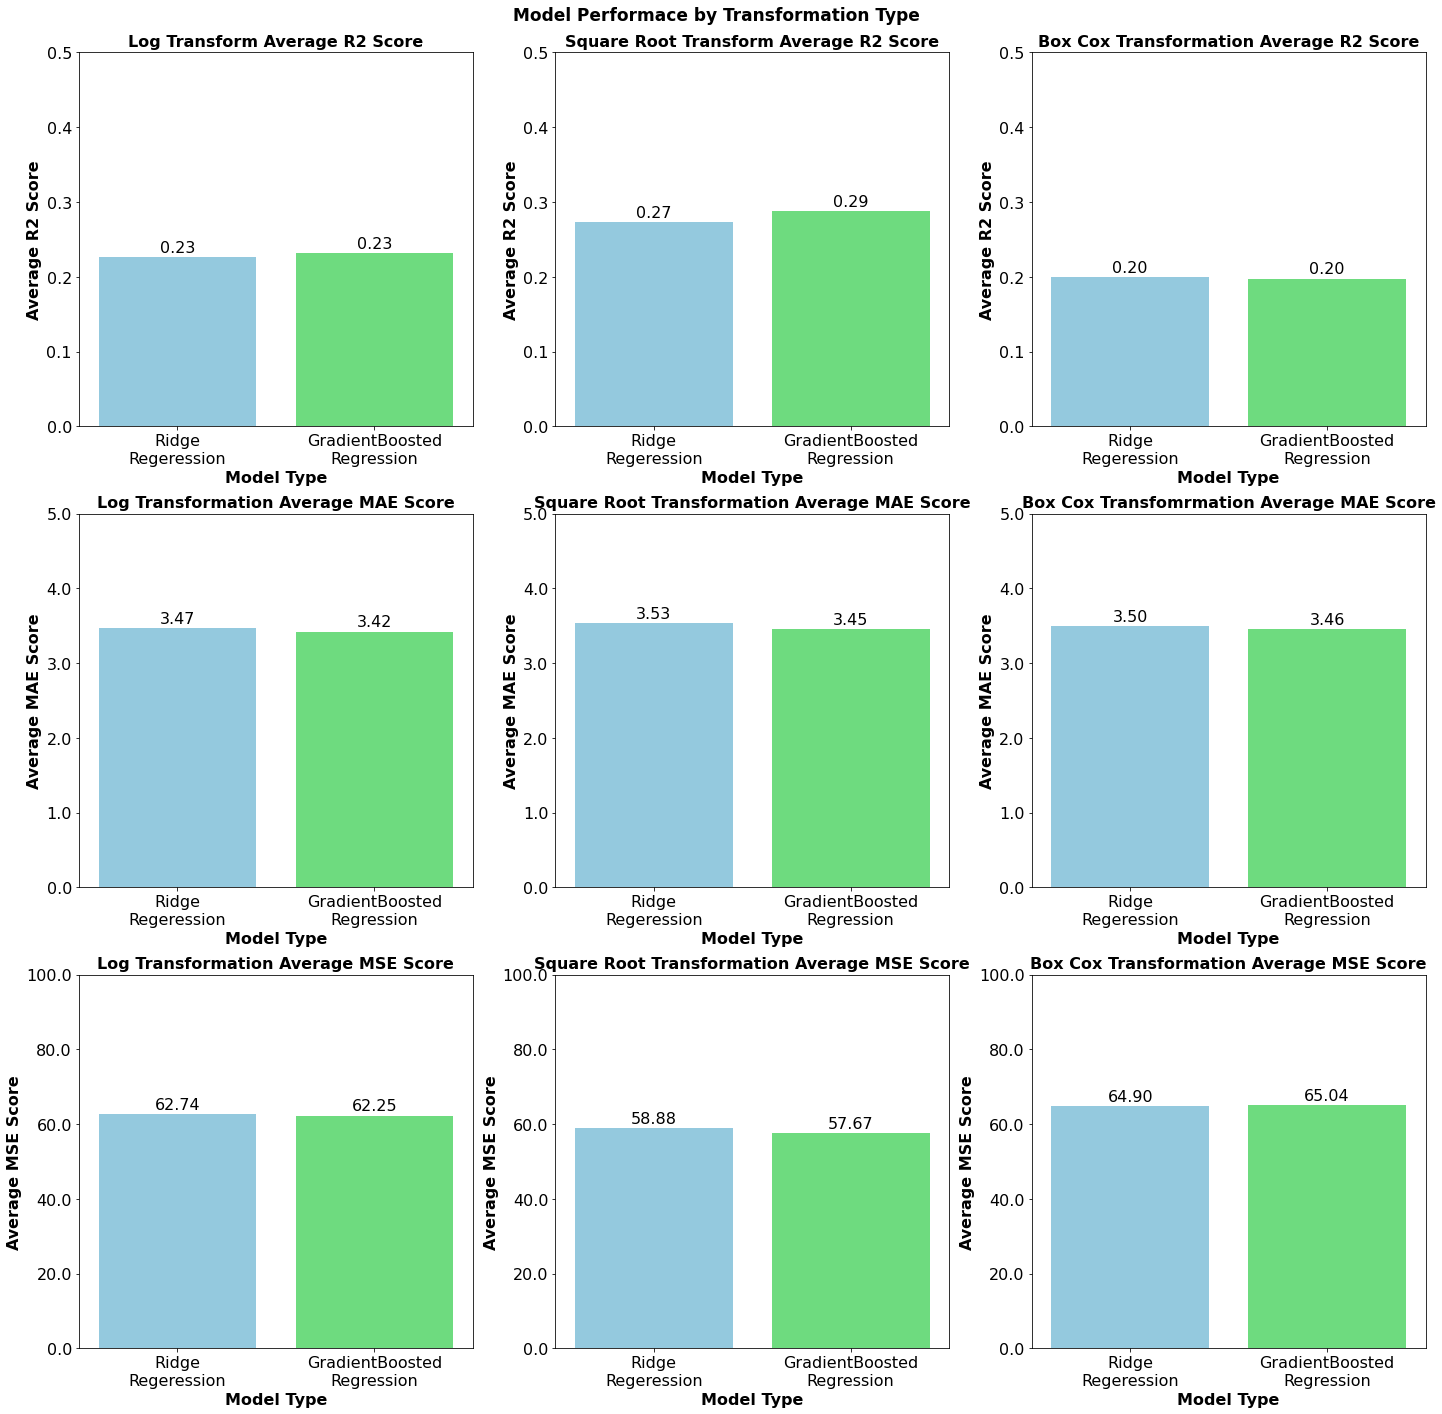

In [10]:
model_scores_transformed_df = pd.DataFrame(data=model_scores_transformed)

log_transform_df = model_scores_transformed_df[model_scores_transformed_df['Transformation'] == 'Log Transform']
sqrt_df = model_scores_transformed_df[model_scores_transformed_df['Transformation'] == 'Square Root']
box_cox_df = model_scores_transformed_df[model_scores_transformed_df['Transformation'] == 'Box-Cox']

color_values = ['skyblue', '#5CED73']

fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharey=False)
fig.subplots_adjust(hspace=0.95, wspace=0.50)
fig.suptitle('Model Performace by Transformation Type', fontsize=17, fontweight='bold')

sns.barplot(ax=axes[0, 0], x=log_transform_df['Model'], y=np.absolute(log_transform_df['avg_r2_score']), palette = color_values)
axes[0, 0].set_title('Log Transform Average R2 Score', fontweight='bold', fontsize=16)
axes[0, 0].set_ylabel('Average R2 Score', fontweight='bold', fontsize=16)
axes[0, 0].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[0, 0].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[0, 0].set_ylim(0, 0.5)
axes[0, 0].bar_label(axes[0, 0].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[0, 0].get_yticks()
axes[0, 0].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[0, 1], x=sqrt_df['Model'], y=np.absolute(sqrt_df['avg_r2_score']), palette = color_values)
axes[0, 1].set_title('Square Root Transform Average R2 Score', fontweight='bold', fontsize=16)
axes[0, 1].set_ylabel('Average R2 Score', fontweight='bold', fontsize=16)
axes[0, 1].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[0, 1].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[0, 1].set_ylim(0, 0.5)
axes[0, 1].bar_label(axes[0, 1].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[0, 1].get_yticks()
axes[0, 1].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[0, 2], x=box_cox_df['Model'], y=np.absolute(box_cox_df['avg_r2_score']), palette = color_values)
axes[0, 2].set_title('Box Cox Transformation Average R2 Score', fontweight='bold', fontsize=16)
axes[0, 2].set_ylabel('Average R2 Score', fontweight='bold', fontsize=16)
axes[0, 2].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[0, 2].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[0, 2].set_ylim(0, 0.5)
axes[0, 2].bar_label(axes[0, 2].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[0, 2].get_yticks()
axes[0, 2].set_yticklabels([round(x, 2) for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[1, 0], x=log_transform_df['Model'], y=np.absolute(log_transform_df['avg_mae_score']), palette = color_values)
axes[1, 0].set_title('Log Transformation Average MAE Score', fontweight='bold', fontsize=16)
axes[1, 0].set_ylabel('Average MAE Score', fontweight='bold', fontsize=16)
axes[1, 0].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[1, 0].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[1, 0].set_ylim(0, 5)
axes[1, 0].bar_label(axes[1, 0].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[1, 0].get_yticks()
axes[1, 0].set_yticklabels([x for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[1, 1], x=sqrt_df['Model'], y=np.absolute(sqrt_df['avg_mae_score']), palette = color_values)
axes[1, 1].set_title('Square Root Transformation Average MAE Score', fontweight='bold', fontsize=16)
axes[1, 1].set_ylabel('Average MAE Score', fontweight='bold', fontsize=16)
axes[1, 1].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[1, 1].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[1, 1].set_ylim(0, 5)
axes[1, 1].bar_label(axes[1,1].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[1, 1].get_yticks()
axes[1, 1].set_yticklabels([x for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[1, 2], x=box_cox_df['Model'], y=np.absolute(box_cox_df['avg_mae_score']), palette = color_values)
axes[1, 2].set_title('Box Cox Transfomrmation Average MAE Score', fontweight='bold', fontsize=16)
axes[1, 2].set_ylabel('Average MAE Score', fontweight='bold', fontsize=16)
axes[1, 2].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[1, 2].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[1, 2].set_ylim(0, 5)
axes[1, 2].bar_label(axes[1, 2].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[1, 2].get_yticks()
axes[1, 2].set_yticklabels([x for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[2, 0], x=log_transform_df['Model'], y=np.absolute(log_transform_df['avg_mse_score']), palette = color_values)
axes[2, 0].set_title('Log Transformation Average MSE Score', fontweight='bold', fontsize=16)
axes[2, 0].set_ylabel('Average MSE Score', fontweight='bold', fontsize=16)
axes[2, 0].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[2, 0].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[2, 0].set_ylim(0, 100)
axes[2, 0].bar_label(axes[2, 0].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[2, 0].get_yticks()
axes[2, 0].set_yticklabels([x for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[2, 1], x=sqrt_df['Model'], y=np.absolute(sqrt_df['avg_mse_score']), palette = color_values)
axes[2, 1].set_title('Square Root Transformation Average MSE Score', fontweight='bold', fontsize=16)
axes[2, 1].set_ylabel('Average MSE Score', fontweight='bold', fontsize=16)
axes[2, 1].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[2, 1].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[2, 1].set_ylim(0, 100)
axes[2, 1].bar_label(axes[2, 1].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[2, 1].get_yticks()
axes[2, 1].set_yticklabels([x for x in current_values_y], fontsize=16)

sns.barplot(ax=axes[2, 2], x=box_cox_df['Model'], y=np.absolute(box_cox_df['avg_mse_score']), palette = color_values)
axes[2, 2].set_title('Box Cox Transformation Average MSE Score', fontweight='bold', fontsize=16)
axes[2, 2].set_ylabel('Average MSE Score', fontweight='bold', fontsize=16)
axes[2, 2].set_xlabel('Model Type', fontweight='bold', fontsize=16)
axes[2, 2].set_xticklabels(labels=['Ridge\nRegeression', 'GradientBoosted\nRegression'], fontsize=16)
axes[2, 2].set_ylim(0, 100)
axes[2, 2].bar_label(axes[2, 2].containers[0], fmt='%.2f', padding=2, fontsize=16)
current_values_y = axes[2, 2].get_yticks()
axes[2, 2].set_yticklabels([x for x in current_values_y], fontsize=16)

plt.tight_layout(rect = [0, 0, 1, 0.988])

In [11]:
params = {
    'regressor__n_estimators': [10, 50, 100, 500],
    'regressor__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'regressor__subsample': [0.5, 0.7, 1.0],
    'regressor__max_depth': [1, 3, 7, 9, 10]
}

grid_search = RandomizedSearchCV(estimator = TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=42), func=np.sqrt, inverse_func=np.square), param_distributions=params, 
                      cv = StratifiedKFold(n_splits=3), n_iter=20, n_jobs = -1, verbose = 2, scoring='r2')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'regressor__subsample': 0.5, 'regressor__n_estimators': 500, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01}
0.2973587232120259


In [25]:
X = all_patient_df.loc[:, ~all_patient_df.columns.isin(['Length of Stay', 'Total Costs', 'Total Charges'])]
y = all_patient_df[['Length of Stay']]

categorical_columns = list(all_patient_df.select_dtypes(include='object'))

X = pd.get_dummies(X)

X = X.loc[:, ~X.columns.isin(categorical_columns)]
y['Length of Stay'] = y['Length of Stay'].astype('float64')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

regr_trans = TransformedTargetRegressor(regressor=GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, n_estimators = 500, subsample = 0.5),
                                        func=np.sqrt, inverse_func=np.square)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
print('=================================================================================================================')
print("R2 Score = ", r2_score(y_test, y_pred), "Mean Absolute Error (MAE) = ", mean_absolute_error(y_test, y_pred), "Mean Squared Error (MSE) = ", mean_squared_error(y_test, y_pred))
print('=================================================================================================================')

<ipython-input-25-3237c1645138>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Length of Stay'] = y['Length of Stay'].astype('float64')


R2 Score =  0.3207445386925978 Mean Absolute Error (MAE) =  3.375525772989769 Mean Squared Error (MSE) =  55.373532076113314


In [20]:
data={'feature_names':regr_trans.regressor_.feature_names_in_,'feature_importance':regr_trans.regressor_.feature_importances_}
features_importance_df = pd.DataFrame(data)
features_importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
features_importance_df.head()
feature_importance_to_10_df = features_importance_df[0:10]

(0.0, 0.5)

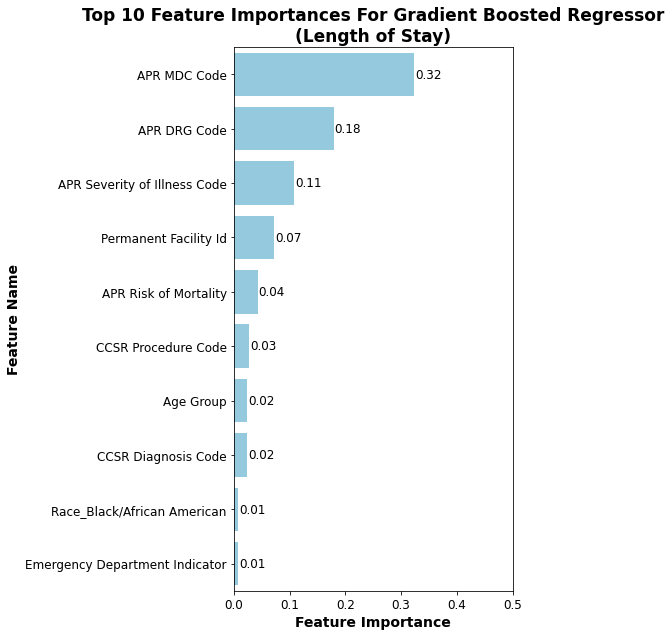

In [24]:
plt.figure(figsize=(5, 10))

sns_barplot = sns.barplot(x=feature_importance_to_10_df['feature_importance'], y=feature_importance_to_10_df['feature_names'], palette = ['skyblue'])
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature Name', fontsize=14, fontweight='bold')
plt.title('Top 10 Feature Importances For Gradient Boosted Regressor\n(Length of Stay)', fontsize=17, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.bar_label(sns_barplot.containers[0], fmt='%.2f', padding=1, fontsize=12)
plt.xlim(0, 0.5)